In [1]:
%pip install tensorflow tensorflow-gpu opencv-python matplotlib
%pip list

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [39 lines of output]
      Traceback (most recent call last):
        File "c:\Users\Cole\anaconda3\envs\dev\lib\site-packages\setuptools\_vendor\packaging\requirements.py", line 35, in __init__
          parsed = _parse_requirement(requirement_string)
        File "c:\Users\Cole\anaconda3\envs\dev\lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 64, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
        File "c:\Users\Cole\anaconda3\envs\dev\lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 82, in _parse_requirement
          url, specifier, marker = _parse_requirement_details(tokenizer)
        File "c:\Users\Cole\anaconda3\envs\dev\lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 126, in _parse_requirement_details
          marker = _parse_requirement_marker(
        Fil

Package                       Version
----------------------------- ---------------
absl-py                       2.1.0
aiobotocore                   2.5.0
aiofiles                      22.1.0
aiohttp                       3.8.5
aioitertools                  0.7.1
aiosignal                     1.2.0
aiosqlite                     0.18.0
alabaster                     0.7.12
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
astunparse                    1.6.3
async-timeout                 4.0.2
atomicwrites                  1.4.0
attrs                         22.1.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.11.0
backcall                      0.2.0
bcrypt                        3.2.0
beautiful

In [2]:
# Import Dependencies
import tensorflow as tf
import os
import cv2
import imghdr
import matplotlib.pyplot as plt

In [3]:
# Verifying correct data separation
print(os.listdir('chest_xray/train'))
os.listdir('chest_xray/test')

['NORMAL', 'PNEUMONIA']


['NORMAL', 'PNEUMONIA']

In [4]:
# Checking image size
img = cv2.imread(os.path.join('chest_xray', 'train', 'NORMAL', 'NORMAL-28501-0001.jpeg'))
img.shape

(2418, 2434, 3)

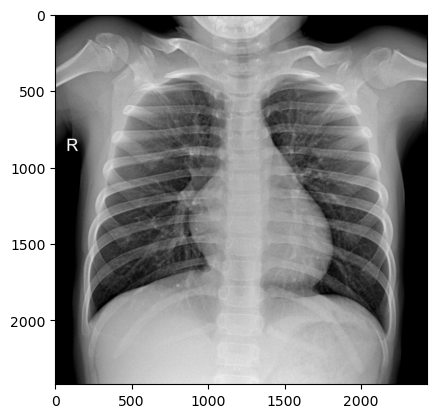

In [5]:
# Example image
plt.imshow(img)

In [6]:
test_data = tf.keras.utils.image_dataset_from_directory('chest_xray/test', batch_size=32)
train_data = tf.keras.utils.image_dataset_from_directory('chest_xray/train', batch_size=32)

Found 624 files belonging to 2 classes.
Found 5232 files belonging to 2 classes.


In [7]:
training_data_iterator = train_data.as_numpy_iterator()
testing_data_iterator = test_data.as_numpy_iterator()

In [8]:
# Getting a batch of data
train_batch = training_data_iterator.next()
test_batch = testing_data_iterator.next()
print(test_batch[0].shape)
train_batch[0].shape

(32, 256, 256, 3)


(32, 256, 256, 3)

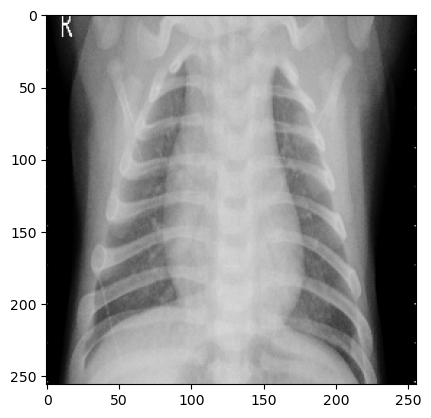

In [9]:
plt.imshow(test_batch[0][0].astype('int'))

In [10]:
# 1 = Pneumonia, 0 = Normal? (Will Double Check Later)
train_batch[1]

array([1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 0])

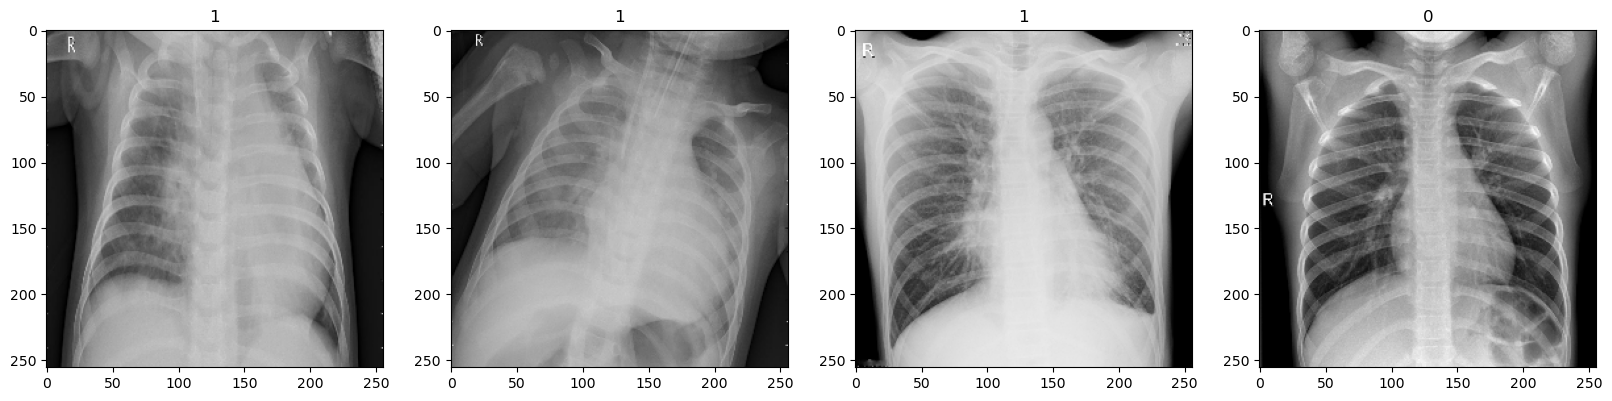

In [11]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(train_batch[0][:4]):
    ax[idx].imshow(img.astype('int'))
    ax[idx].set_title(train_batch[1][idx])

In [12]:
# Initial bounds
print(train_batch[0].min(), train_batch[0].max())
print(test_batch[0].min(), test_batch[0].max())

0.0 255.0
0.0 255.0


In [13]:
# Scaled data bounds
train_scaled = train_batch[0] / 255
test_scaled = test_batch[0] / 255

print(train_scaled.min(), train_scaled.max())
print(test_scaled.min(), test_scaled.max())

0.0 1.0
0.0 1.0


# PreProcessing

In [14]:
train_scaled_data = train_data.map(lambda x, y: (x/255, y))
test_scaled_data = test_data.map(lambda x, y: (x/255, y))

In [15]:
train_scaled_data.as_numpy_iterator().next()[0].max(), train_scaled_data.as_numpy_iterator().next()[0].min()
test_scaled_data.as_numpy_iterator().next()[0].max(), test_scaled_data.as_numpy_iterator().next()[0].min()

(1.0, 0.0)

In [16]:
print(len(train_scaled_data))
print(len(test_scaled_data))

164
20


# Building the Model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [18]:
model = Sequential()

In [19]:
# Add a 2D convolutional layer with 16 filters, a 3x3 kernel, Stride of 1, and ReLU activation
# Input shape is (256, 256, 3)
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))

# Add a max pooling layer
model.add(MaxPooling2D())

# Add another 2D convolutional layer with 32 filters, a 3x3 kernel, and ReLU activation
model.add(Conv2D(32, (3,3), 1, activation='relu'))

# Add another max pooling layer
model.add(MaxPooling2D())

# Add another 2D convolutional layer with 16 filters, a 3x3 kernel, and ReLU activation
model.add(Conv2D(16, (3,3), 1, activation='relu'))

# Add another max pooling layer
model.add(MaxPooling2D())

# Flatten the output of the previous layer
model.add(Flatten())

# Add a fully connected layer with 256 units and ReLU activation
model.add(Dense(256, activation='relu'))

# Add a final fully connected layer with 1 unit and sigmoid activation
model.add(Dense(1, activation='sigmoid'))

In [20]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

In [22]:
hist = model.fit(train_scaled_data, epochs=10)

Epoch 1/10




164/164 [==============================] - 14s 80ms/step - loss: 0.2705 - accuracy: 0.8878
Epoch 2/10
164/164 [==============================] - 13s 79ms/step - loss: 0.1068 - accuracy: 0.9618
Epoch 3/10
164/164 [==============================] - 13s 78ms/step - loss: 0.0834 - accuracy: 0.9690
Epoch 4/10
164/164 [==============================] - 13s 78ms/step - loss: 0.0622 - accuracy: 0.9786
Epoch 5/10
164/164 [==============================] - 13s 79ms/step - loss: 0.0503 - accuracy: 0.9820
Epoch 6/10
164/164 [==============================] - 13s 79ms/step - loss: 0.0479 - accuracy: 0.9822
Epoch 7/10
164/164 [==============================] - 13s 78ms/step - loss: 0.0280 - accuracy: 0.9895
Epoch 8/10
164/164 [==============================] - 13s 78ms/step - loss: 0.0231 - accuracy: 0.9924
Epoch 9/10
164/164 [==============================] - 13s 79ms/step - loss: 0.0185 - accuracy: 0.9925
Epoch 10/10
164/164 [==============================] - 13s 80ms/step - loss: 0.0242 - accur

In [23]:
hist.history

{'loss': [0.2704886198043823,
  0.10683482885360718,
  0.0833539217710495,
  0.06218837946653366,
  0.050338633358478546,
  0.04791786149144173,
  0.02802572026848793,
  0.023064536973834038,
  0.01848074048757553,
  0.024188581854104996],
 'accuracy': [0.8878058195114136,
  0.961773693561554,
  0.9690366983413696,
  0.9785932898521423,
  0.9820336103439331,
  0.9822247624397278,
  0.9894877672195435,
  0.9923547506332397,
  0.9925458431243896,
  0.9902523159980774]}

# Plotting

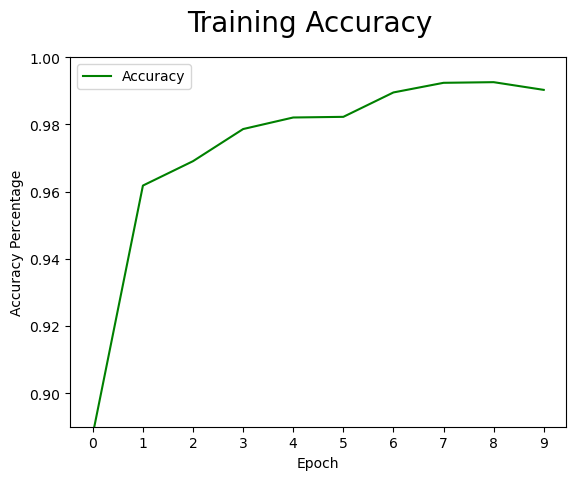

In [24]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='green', label='Accuracy')
fig.suptitle('Training Accuracy', fontsize=20)
plt.legend(loc='best')
plt.xticks(range(0,10))
plt.ylim(0.89,1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy Percentage')
plt.show()

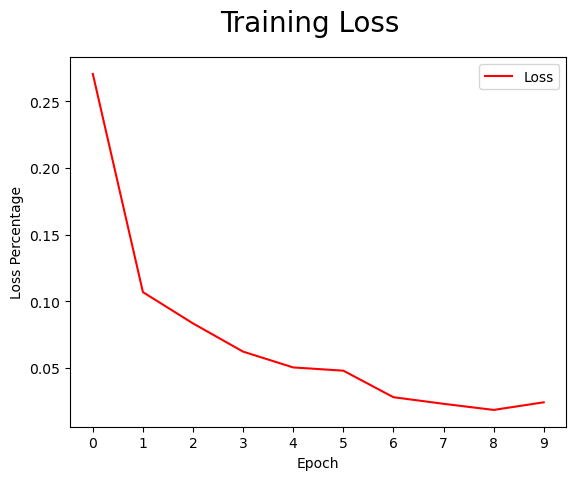

In [25]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='red', label='Loss')
fig.suptitle('Training Loss', fontsize=20)
plt.legend(loc='best')
plt.xticks(range(0,10))
plt.xlabel('Epoch')
plt.ylabel('Loss Percentage')
plt.show()

# Evaluation

In [26]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [27]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [28]:
len(test_scaled_data)

20

In [29]:
for batch in test_scaled_data.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 74ms/step


In [30]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.7633135914802551, Recall: 0.9923076629638672, Accuracy: 0.8028846383094788


# Test